<a href="https://colab.research.google.com/github/Andre6o6/stylegan-editing/blob/master/StyleGAN_edit_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook shows the example of image editing

In [ ]:
#@title Load dependences {display-mode: "form"}

%tensorflow_version 1.x

!git clone https://github.com/Andre6o6/stylegan-editing.git stylegan_editing
%cd stylegan_editing

#TODO as submodule
!git clone https://github.com/genforce/interfacegan.git

# Load pretrained models
!gdown --id 1r3Qygz6DaXtQwkUbd35ucA2U4hayj32m
!mv karras2019stylegan-ffhq-1024x1024.pkl interfacegan/models/pretrain/
!gdown --id 1C9MSghPDWnkccGXgU6S9-wnRgPVBVovL

!pip install facenet-pytorch


---

In [ ]:
#@title Upload your images {display-mode: "form"}

import os
from google.colab import files

os.makedirs("latents", exist_ok=True)
os.makedirs("raw_images", exist_ok=True)
os.makedirs("aligned_images", exist_ok=True)

uploaded = files.upload()
for fn in uploaded.keys():
    os.rename(fn, os.path.join("raw_images", fn))

In [ ]:
#@title (Optional) or download images, picked from FEI Face Database {display-mode: "form"}

!mkdir latents/ raw_images/ aligned_images/

%cd raw_images/
!gdown --id 1qnf8pbtTmBguMUAre0ZeC1F_DqpWnFcp
#!gdown --id 1eFKVKEGsGr9Yl-uI3lC3XaqthAX8uPl4
!gdown --id 1KzXBdEvTyhyyWuPwJpGC05Ix6HU1foVm
#!gdown --id 1vPOidmfgxvsks3hfqOya_WfNElkwlcDo
#!gdown --id 1hkQZH8DoPioUMkr60S5MM3OjYlJgvnK5
!gdown --id 1Br3jI1ae2T0eN0TNHDfistlb1fshLQdR
%cd ..


---

In [ ]:
#@title Align images {display-mode: "form"}

!python align/align_images.py raw_images/ aligned_images/ --output_size=1024


---

In [ ]:
#@title Encode images in StyleGAN latent space... {display-mode: "form"}

!python encode_images.py

[2021-05-18 13:45:33,524][INFO] Loading pytorch model from `interfacegan/models/pretrain/stylegan_ffhq.pth`.
[2021-05-18 13:45:33,811][INFO] Successfully loaded!
[2021-05-18 13:45:33,814][INFO]   `lod` of the loaded model is 0.0.

		Input		Reconstruction


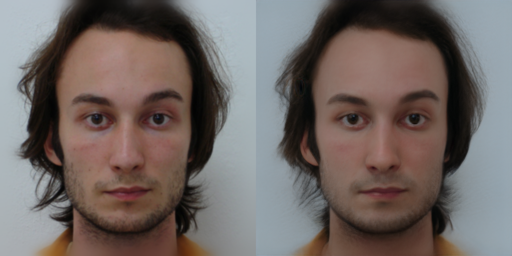

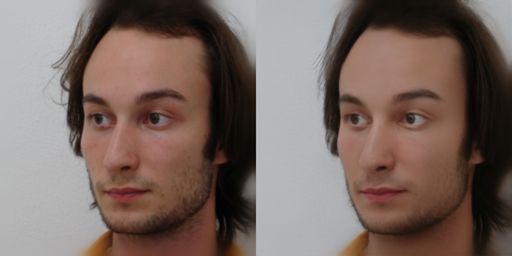

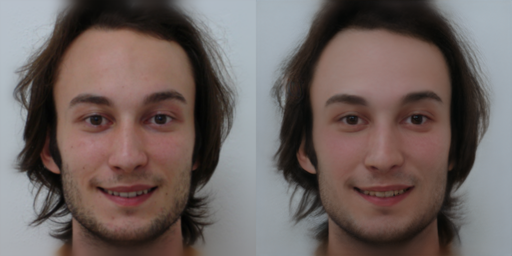

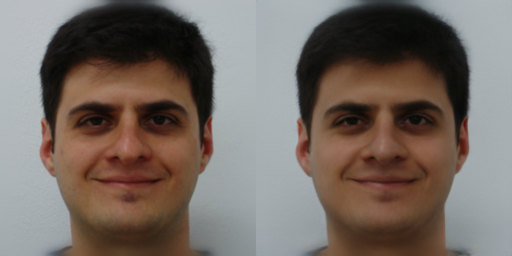

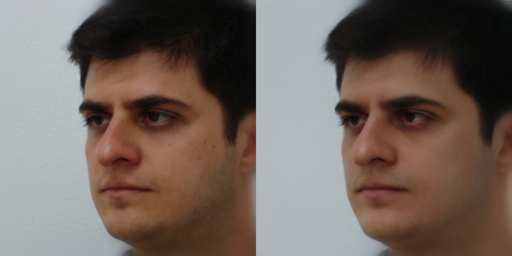

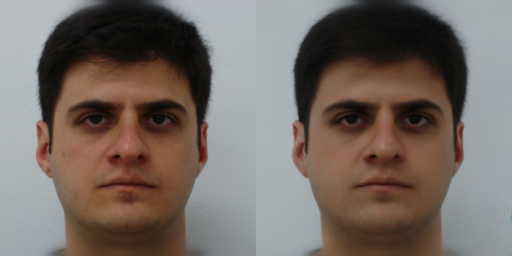

In [47]:
#@title ...and show results: {display-mode: "form"}

import numpy as np
import os
from PIL import Image
from interfacegan.models.stylegan_generator import StyleGANGenerator

def get_image_numpy(tensor):
    img = tensor.detach().cpu().squeeze().numpy()
    img = img.transpose((1,2,0))
    #img = (img - img.min())/(img.max() - img.min())
    img = (255*img).astype(np.uint8)
    return img

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
converted_model = StyleGANGenerator("stylegan_ffhq")
latent_optimizer = LatentOptimizer(converted_model.model)

print("\n\t\tInput\t\tReconstruction")
for imgname in os.listdir("aligned_images"):
    img_path = "aligned_images/" + imgname
    latent_path = "latents/" + imgname + ".npy"

    img = np.array(Image.open(img_path))

    latent = np.load(latent_path)
    #g = converted_model.synthesize(latent, "WP")
    #g = converted_model.postprocess(g["image"])[0]
    _, generated_image = latent_optimizer(torch.from_numpy(latent).to(device))
    g = get_image_numpy(generated_image)

    imgs_comb = np.hstack((img, g))
    display(Image.fromarray(imgs_comb).resize((512,256)))


---

## Edit image

In [85]:
#@title Run UI

import ipywidgets as widgets

if feature is None:
    feature = "pose"

img_list = os.listdir("aligned_images/")
input_picker = widgets.Dropdown(options=img_list)
exemplar_picker = widgets.Dropdown(options=img_list)
feature_picker = widgets.Dropdown(options=["pose", "smile"], value="pose")

print("Choose exemplar image, from which feature will be transfered:")
display(exemplar_picker)
print("Choose your target image for feature transfer:")
display(input_picker)
print("Choose feature to transfer:")
display(feature_picker)

def display_feature_ui(exemplar, input, feature):
    print(f"{feature} transfer: {exemplar} --> {input}")
    paths = ["aligned_images/"+x for x in [exemplar, input]]
    imgs = [Image.open(x).resize((256,256)) for x in paths]
    imgs_comb = np.hstack( [np.asarray(x) for x in imgs] )
    display(Image.fromarray(imgs_comb))

out = widgets.interactive_output(
    display_feature_ui, 
    {"exemplar": exemplar_picker, "input": input_picker, "feature": feature_picker}
)

display(out)

Choose exemplar image, from which feature will be transfered:


Dropdown(options=('fei2-neutral_01.png', 'fei2-pose_01.png', 'fei2-smile_01.png', 'fei1-smile_01.png', 'fei1-p…

Choose your target image for feature transfer:


Dropdown(options=('fei2-neutral_01.png', 'fei2-pose_01.png', 'fei2-smile_01.png', 'fei1-smile_01.png', 'fei1-p…

Choose feature to transfer:


Dropdown(options=('pose', 'smile'), value='pose')

Output()

https://colab.research.google.com/github/harskish/ganspace/blob/master/notebooks/Ganspace_colab.ipynb#scrollTo=wJytqjrVwZ7K

In [ ]:
import numpy as np
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from facenet_pytorch import InceptionResnetV1
from interfacegan.models.stylegan_generator import StyleGANGenerator
from models.latent_optimization import LatentOptimizer
from edit_images import morph_coefficient, feature_morph

# TODO slider for strength

# Load models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
converted_model = StyleGANGenerator("stylegan_ffhq")
latent_optimizer = LatentOptimizer(converted_model.model, latent_space="WP")
facenet = InceptionResnetV1(pretrained='vggface2').to(device).eval()

# Get feature vector
if (feature == "smile"):
    boundary = np.load("boundaries/stylegan_ffhq_smile_w_boundary.npy")
elif (feature == "pose"):
    boundary = np.load("boundaries/stylegan_ffhq_pose_w_boundary.npy")

# Get latent vectors
w_input = "latents/" + input_picker.value + ".npy"
w_exemplar = "latents/" + exemplar_picker.value + ".npy"
effect_coef = morph_coefficient(w_input, w_exemplar, boundary, map_k=5)

## Calculate direction, corresponding to semantic change

In [ ]:
#!pip install ffmpeg-python
#!pip install scikit-video

In [ ]:
converted_model = StyleGANGenerator("stylegan_ffhq")

In [ ]:
anim = []
n_frames = 120
base = np.load("latents/11-13_01.png.npy")

for w in np.linspace(base, base+2*diff, n_frames):
    g = generate_image(w)
    anim.append(g)
skvideo.io.vwrite("headpose.mp4", anim)

In [ ]:
clip = VideoFileClip('headpose.mp4')
clip.ipython_display(height=512, autoplay=1, loop=1)

 99%|█████████▉| 120/121 [00:02<00:00, 50.22it/s]
